In [2]:
from google.colab import drive
drive.mount("/content/drive")

In [3]:
import sys
sys.path.append("/content/drive/MyDrive/")
#%cd /content/gdrive/MyDrive/rhinoceros_hippopotamus_classification

Mounted at /content/gdrive
/content/gdrive/MyDrive/rhinoceros_hippopotamus_classification


In [5]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 9.1 MB/s eta 0:00:00


In [52]:
from transformers import ViTForImageClassification,ViTConfig, ViTImageProcessor
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader,TensorDataset
from torchvision import transforms
from tqdm import tqdm
from torchmetrics.functional import accuracy
import matplotlib.pyplot as plt
from pathlib import Path

from utils import load_dataset

In [53]:
save_path = Path("model.pch")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Freeze le model
for parameter in  model.parameters() :
  parameter.requires_grad = False

# Changer la derniere couche
nb_classe = 2
model.classifier = nn.Linear(model.config.hidden_size, nb_classe)

In [54]:
train_images, train_labels = load_dataset(test=False, color=True)
test_images, test_labels = load_dataset(test=True, color=True)

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

tensor_tr = torch.stack([transform_data(image) for image in train_images])
tensor_ts = torch.stack([transform_data(image) for image in test_images])


tensor_test = tensor_ts.expand(-1, 3, -1, -1).to(torch.float32)
tensor_train = tensor_tr.expand(-1, 3, -1, -1).to(torch.float32)

train_tensor = TensorDataset(tensor_train,torch.tensor(train_labels, dtype = torch.long))
test_tensor = TensorDataset(tensor_test,torch.tensor(test_labels, dtype = torch.long))

BATCH_SIZE = 64

Train = DataLoader(train_tensor,shuffle=True, batch_size = BATCH_SIZE)
Test = DataLoader(test_tensor,shuffle = False)

In [55]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')

In [56]:
num_epochs = 10
model = model.to(device)
accuracy_train = []
loss_train = []

accuracy_test = []
loss_test = []

for epoch in range(num_epochs):
  acc_accuracy_train = 0
  acc_accuracy_test = 0
  acc_loss_train = 0
  acc_loss_test = 0
  data_train_tqdm = tqdm(Train,desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False, dynamic_ncols=True)

  for data,label in data_train_tqdm:
      # Forward pass
      data = data.to(device)
      label = label.to(device)
      outputs = model(data)
      prediction = outputs.logits
      predict_final = torch.argmax(prediction, axis = 1)
      acc_accuracy_train += accuracy(predict_final,label, task = "BINARY")
      loss_ = loss(prediction, label)
      acc_loss_train += loss_.item()
      optimizer.zero_grad()
      loss_.backward()
      optimizer.step()

  if epoch %  10 == 0 :
    with save_path.open('wb') as fp :
      torch.save(model,fp)

  acc = (acc_accuracy_train / len(Train))
  accuracy_train.append(acc)
  loss_train.append(acc_loss_train)


  with torch.no_grad() :
    for data_test,label_test in Test :
      data_test = data_test.to(device)
      label_test = label_test.to(device)
      output = model(data_test)
      prediction = output.logits
      acc_loss_test += loss(prediction,label_test).item()
      acc_accuracy_test += accuracy(torch.argmax(prediction,axis = 1),label_test,task = "BINARY")

  accuracy_test.append(acc_accuracy_test/len(Test))
  loss_test.append(acc_loss_test)

In [57]:
list_acc_train = [acc.item() for acc in accuracy_train]
list_acc_test = [acc.item() for acc in accuracy_test]

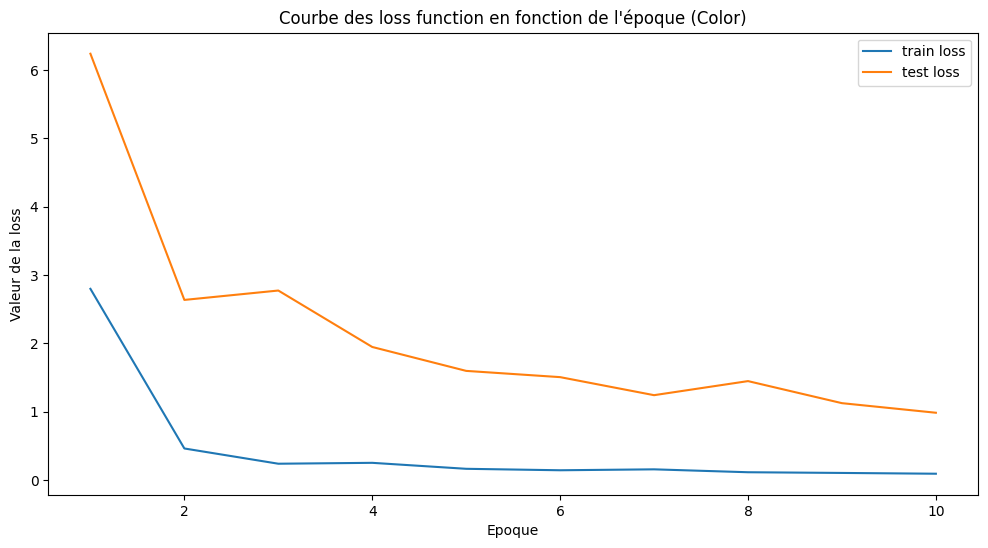

In [60]:
plt.figure(figsize=(12, 6))
epochs = range(1,num_epochs+1)

plt.title("Courbe des loss function en fonction de l'époque (Color)")
plt.xlabel('Epoque')
plt.ylabel("Valeur de la loss")
plt.plot(epochs,loss_train, label = "train loss")
plt.plot(epochs,loss_test, label = "test loss")
plt.legend()


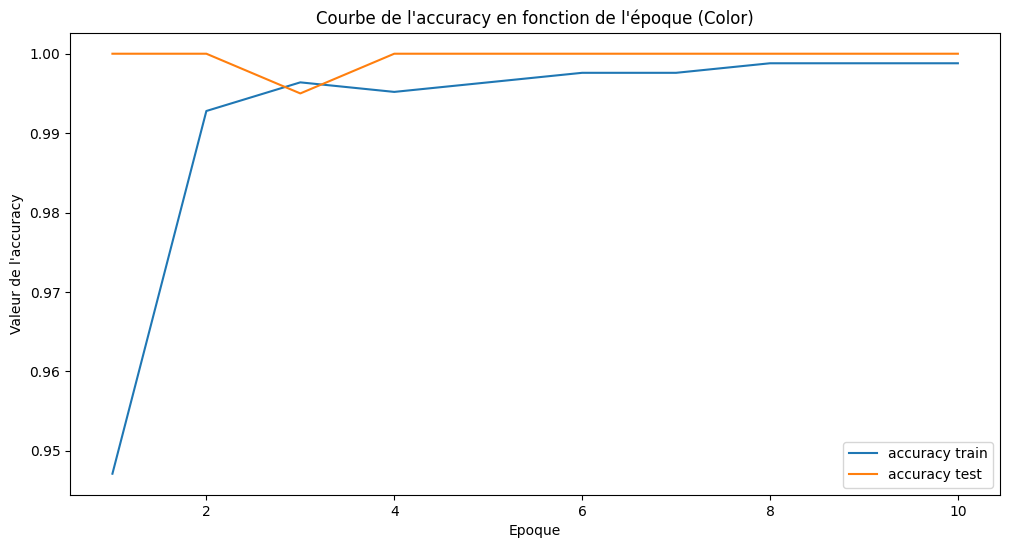

In [61]:
plt.figure(figsize=(12, 6))
epochs = range(1,num_epochs+1)

plt.title("Courbe de l'accuracy en fonction de l'époque (Color)")
plt.xlabel('Epoque')
plt.ylabel("Valeur de l'accuracy")

plt.plot(epochs,list_acc_train,label = "accuracy train")
plt.plot(epochs,list_acc_test,label = "accuracy test")
plt.legend()
